# Importance Reweighting

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(510)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

# Importance Sampling

Nested Sampling provides both a set of samples and their associated **importance weights**. These are exactly analagous to those provided by **importance sampling**, where we want to estimate some function $f(\mathbf{x})$ relative to a target distribution $p(\mathbf{x})$ using some proposal distribution $q(\mathbf{x})$ using $N$ Monte Carlo samples $\mathbf{x}_i$ drawn from $q(\mathbf{x})$ via

$$ 
\mathbb{E}[f(\mathbf{x})] = \int f(\mathbf{x}) p(\mathbf{x}) d\mathbf{x} 
= \int f(\mathbf{x}) q(\mathbf{x}) \frac{p(\mathbf{x})}{q(\mathbf{x})} d\mathbf{x}
\approx \frac{1}{N} \sum_{i=1}^{N} f(\mathbf{x}_i) \frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)} 
\: \text{where} \:
\mathbf{x}_i \sim q(\mathbf{x})
$$

This means that by assigning each sample $\mathbf{x}_i$ its importance weight $w_i \equiv p(\mathbf{x}_i) / q(\mathbf{x}_i)$, we can estimate any posterior-related quantity as well as its integral (i.e. the evidence). In Nested Sampling, $q(\mathbf{x})$ is constructed/estimated from the actual sampling process.

Within an importance sampling framework, it is straightforward to update to a new target distribution $p^\prime(\mathbf{x})$ using the previous set of importance weights since

$$ 
w^\prime_i \equiv \frac{p^\prime(\mathbf{x}_i)}{q(\mathbf{x}_i)} 
= \frac{p^\prime(\mathbf{x}_i)}{p(\mathbf{x}_i)}\frac{p(\mathbf{x}_i)}{q(\mathbf{x}_i)} =
\frac{p^\prime(\mathbf{x}_i)}{p(\mathbf{x}_i)} w_i
$$

Since the Nested Sampling weights are importance weights, it is also straightforward to update these a new target distribution if we want to "swap out" our posteriors.

There are two important caveats to this:
1. This process can only work if the pre-existing samples have sufficient **coverage**, meaning that they span the majority of the new target distribution. If they don't encompass the majority of the new parameter space, the results will be inevitably biased.
2. In addition to reasonable coverage, samples must also be sufficiently **dense** relative to the new target distribution. If samples are sparse, then reweighting can lead to a much noisier estimates.
As a result, importance reweighting is most useful when "tweaking" a distribution and least useful when trying to make big changes.

# 3-D Multivariate Normal

We will demonstrate importance reweighting using 3-D **multivariate Normal** distributions. First, we will define the correlated version used in previous examples.

In [4]:
ndim = 3  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

We'll again define our prior (via `prior_transform`) to be uniform in each dimension from -10 to 10 and 0 everywhere else.

In [5]:
# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -10. and 10. in each variable."""
    return 10. * (2. * u - 1.)

Let's first generate samples from this target distribution.

In [6]:
# initialize our nested sampler
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim=3,
                                        bound='single', sample='unif', rstate=rstate)
dsampler.run_nested(maxiter=50000, use_stop=False)
dres = dsampler.results

49497it [15:53, 345.44it/s, batch: 22 | bound: 2 | nc: 2 | ncall: 877292 | eff(%):  5.639 | loglstar:   -inf < -2.603 < -1.059 | logz: -8.965 +/-  0.044 | stop:    nan]            /home/koposov/pyenv38/lib/python3.8/site-packages/dynesty/dynamicsampler.py:1317: UserWarning: Warning. The maximum likelihood not reached in the batch. You may not have enough livepoints
  warnings.warn('Warning. The maximum likelihood not reached '
50000it [15:57, 52.22it/s, batch: 22 | bound: 2 | nc: 1 | ncall: 877797 | eff(%):  5.696 | loglstar:   -inf < -0.407 < -1.059 | logz: -8.965 +/-  0.044 | stop:    nan] 


Now let's generate samples from the uncorrelated version with the same priors.

In [7]:
C2 = np.identity(ndim)  # set covariance to identity matrix
Cinv2 = linalg.inv(C2)  # precision matrix
lnorm2 = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C2)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood2(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv2, x)) + lnorm2

In [8]:
dsampler2 = dynesty.DynamicNestedSampler(loglikelihood2, prior_transform, ndim=3,
                                         bound='single', sample='unif', rstate=rstate)
dsampler2.run_nested(maxiter=50000, use_stop=False)
dres2 = dsampler2.results

49492it [10:51, 174.45it/s, batch: 23 | bound: 6 | nc: 1 | ncall: 675097 | eff(%):  7.325 | loglstar: -13.723 < -3.575 < -3.541 | logz: -8.958 +/-  0.036 | stop:    nan]         /home/koposov/pyenv38/lib/python3.8/site-packages/dynesty/dynamicsampler.py:1317: UserWarning: Warning. The maximum likelihood not reached in the batch. You may not have enough livepoints
  warnings.warn('Warning. The maximum likelihood not reached '
50000it [10:56, 76.17it/s, batch: 23 | bound: 6 | nc: 1 | ncall: 675697 | eff(%):  7.400 | loglstar: -13.723 < -2.763 < -3.541 | logz: -8.958 +/-  0.036 | stop:    nan] 


Comparing our results shows these distributions are somewhat different.

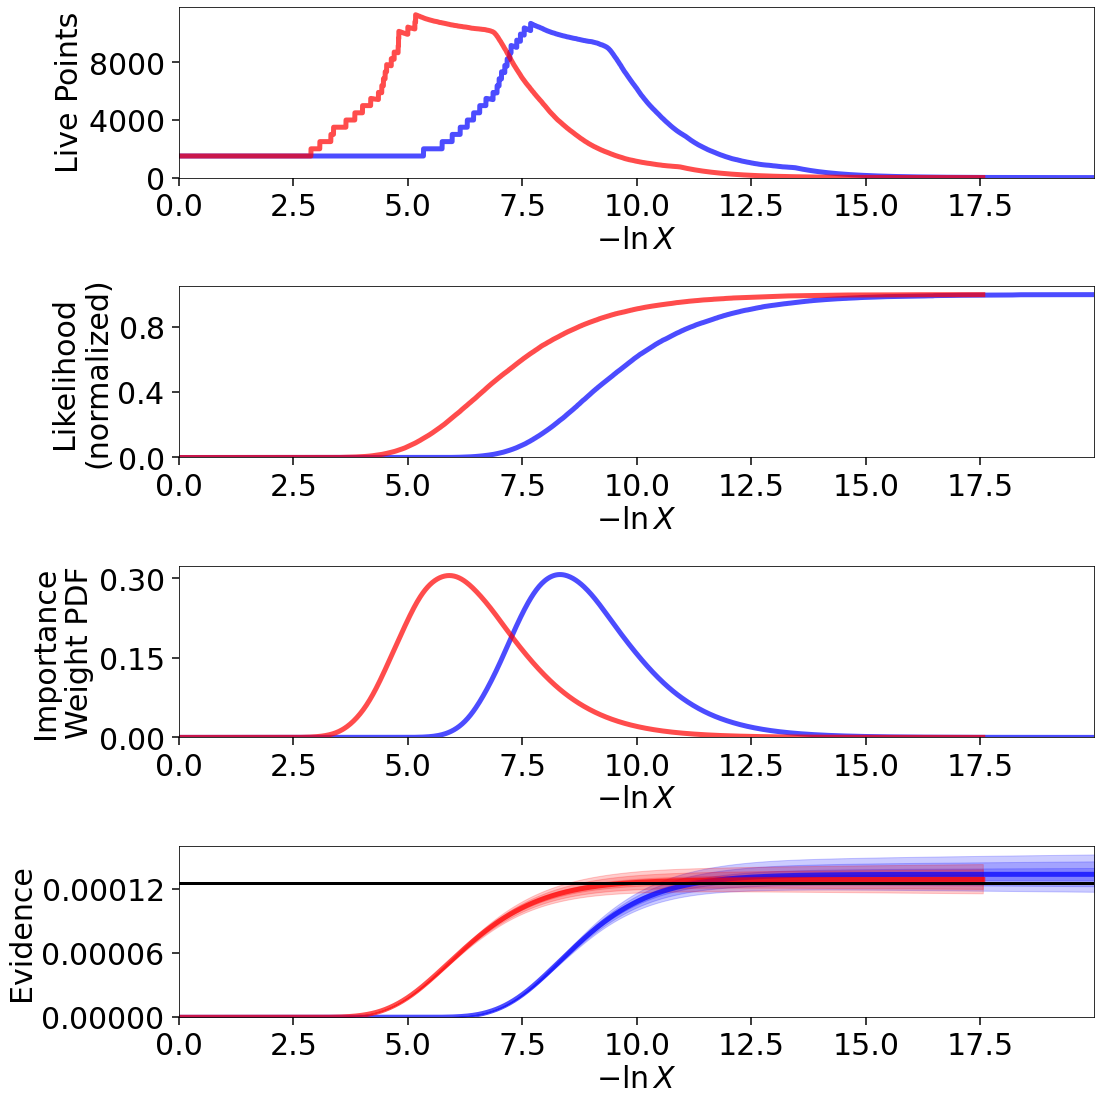

In [9]:
# plot results
from dynesty import plotting as dyplot

lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(dres, color='blue')
fig, axes = dyplot.runplot(dres2, color='red', 
                           lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

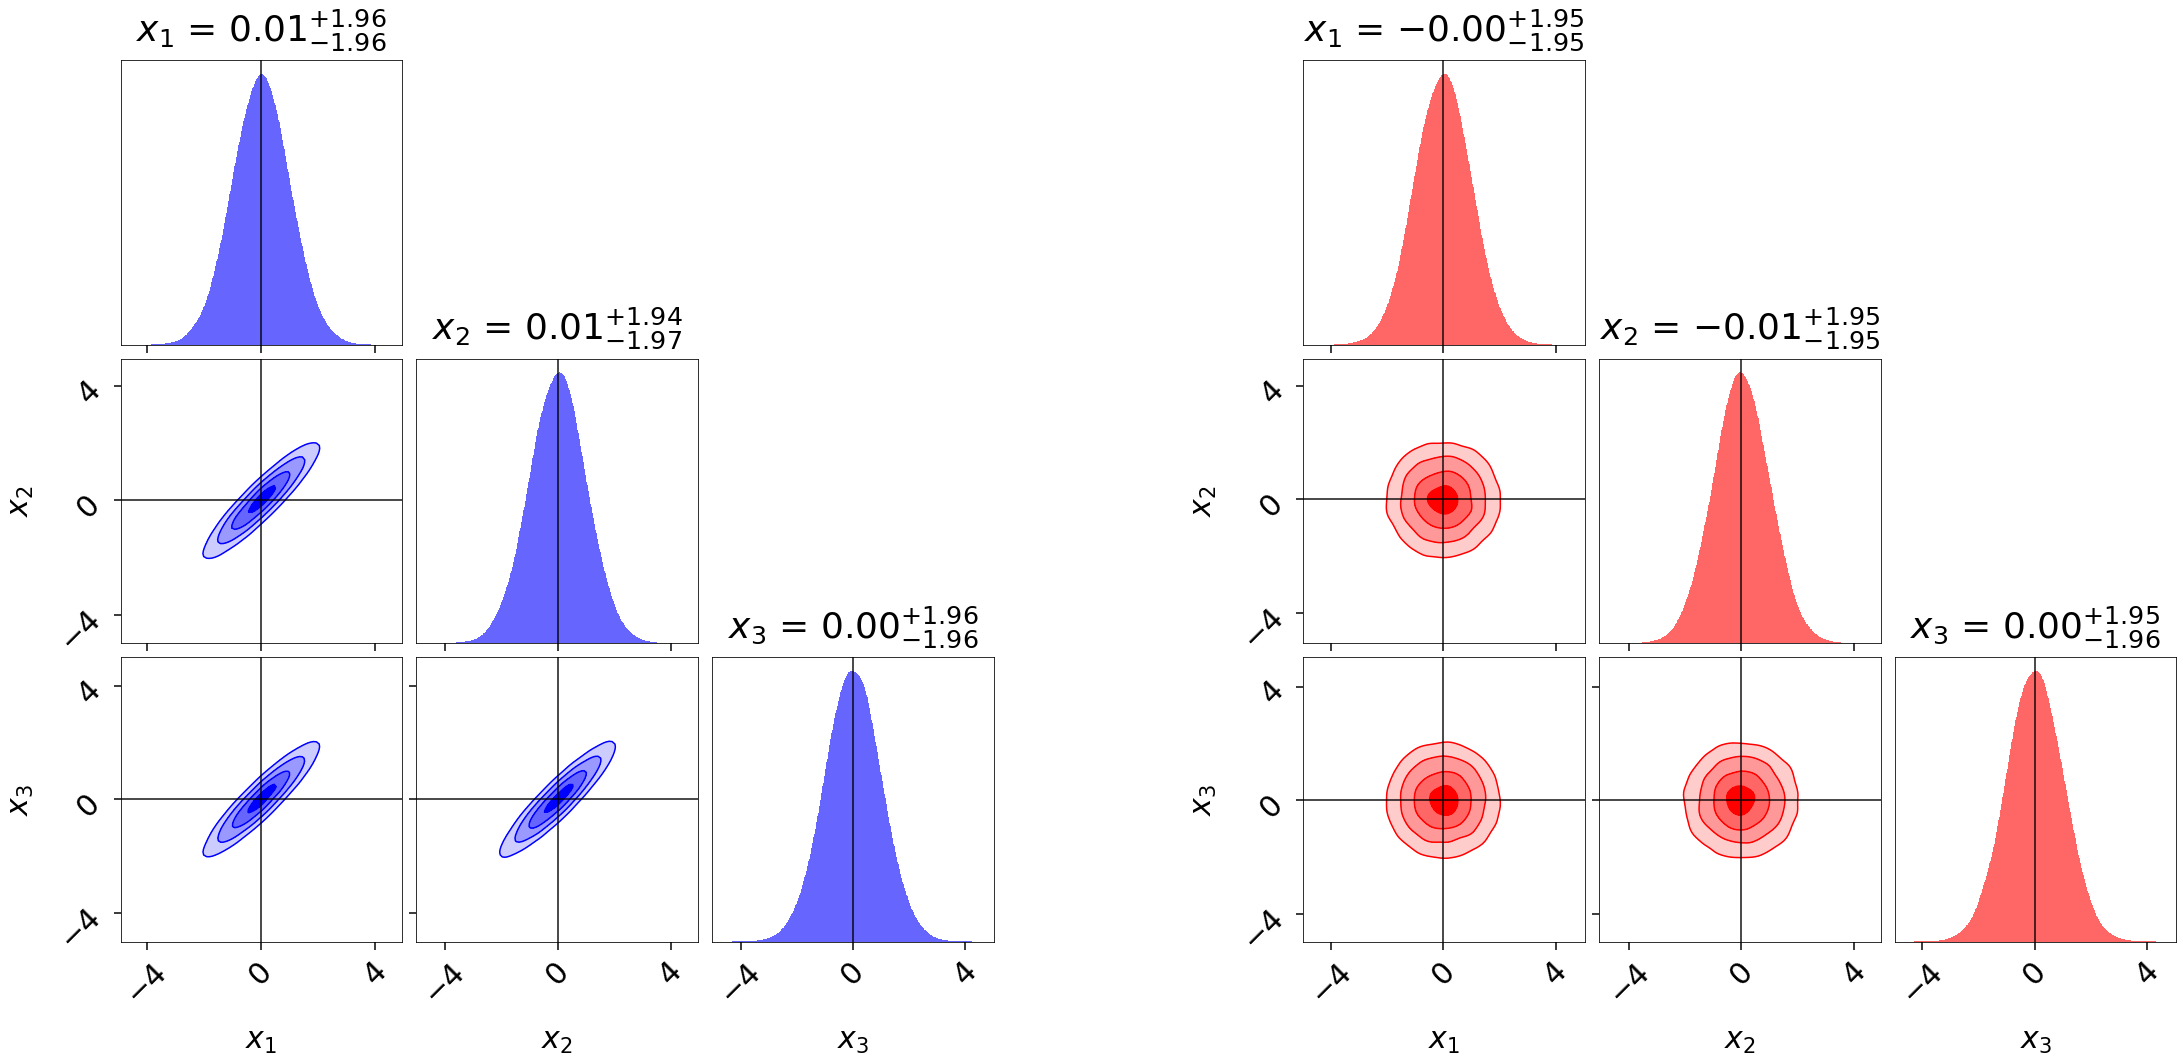

In [10]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(dres, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(dres2, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))

Let's using importance reweighting to adjust each of our samples to try and approximate the other distribution.

In [11]:
# compute new log-likelihoods
logl = np.array([loglikelihood(s) for s in dres2.samples])
logl2 = np.array([loglikelihood2(s) for s in dres.samples])

# reweight results
dres_rwt = dynesty.utils.reweight_run(dres, logp_new=logl2)
dres2_rwt = dynesty.utils.reweight_run(dres2, logp_new=logl)

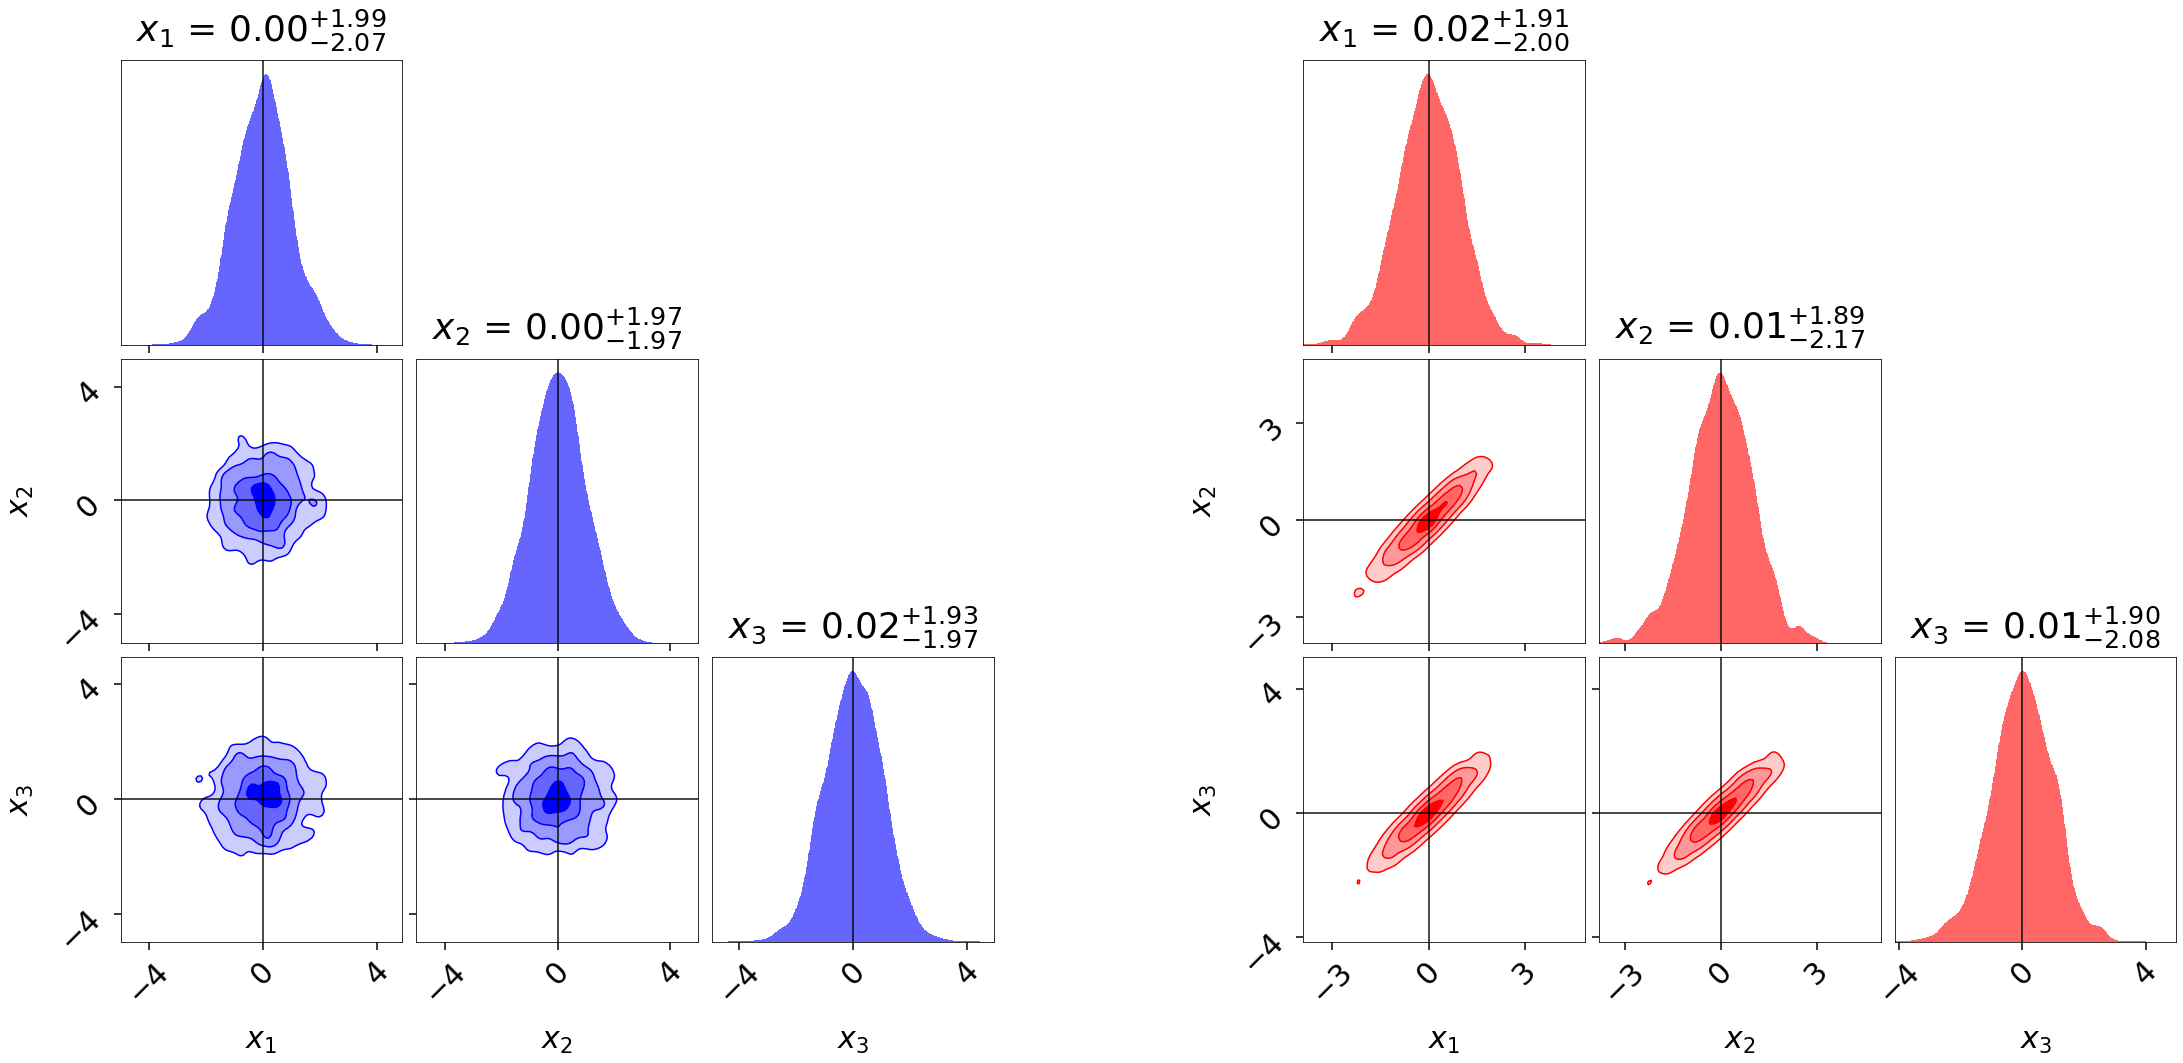

In [12]:
# initialize figure
fig, axes = plt.subplots(3, 7, figsize=(35, 15))
axes = axes.reshape((3, 7))
[a.set_frame_on(False) for a in axes[:, 3]]
[a.set_xticks([]) for a in axes[:, 3]]
[a.set_yticks([]) for a in axes[:, 3]]

# plot initial run (left)
fg, ax = dyplot.cornerplot(dres_rwt, color='blue', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :3]))

# plot extended run (right)
fg, ax = dyplot.cornerplot(dres2_rwt, color='red', truths=[0., 0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 4:]))

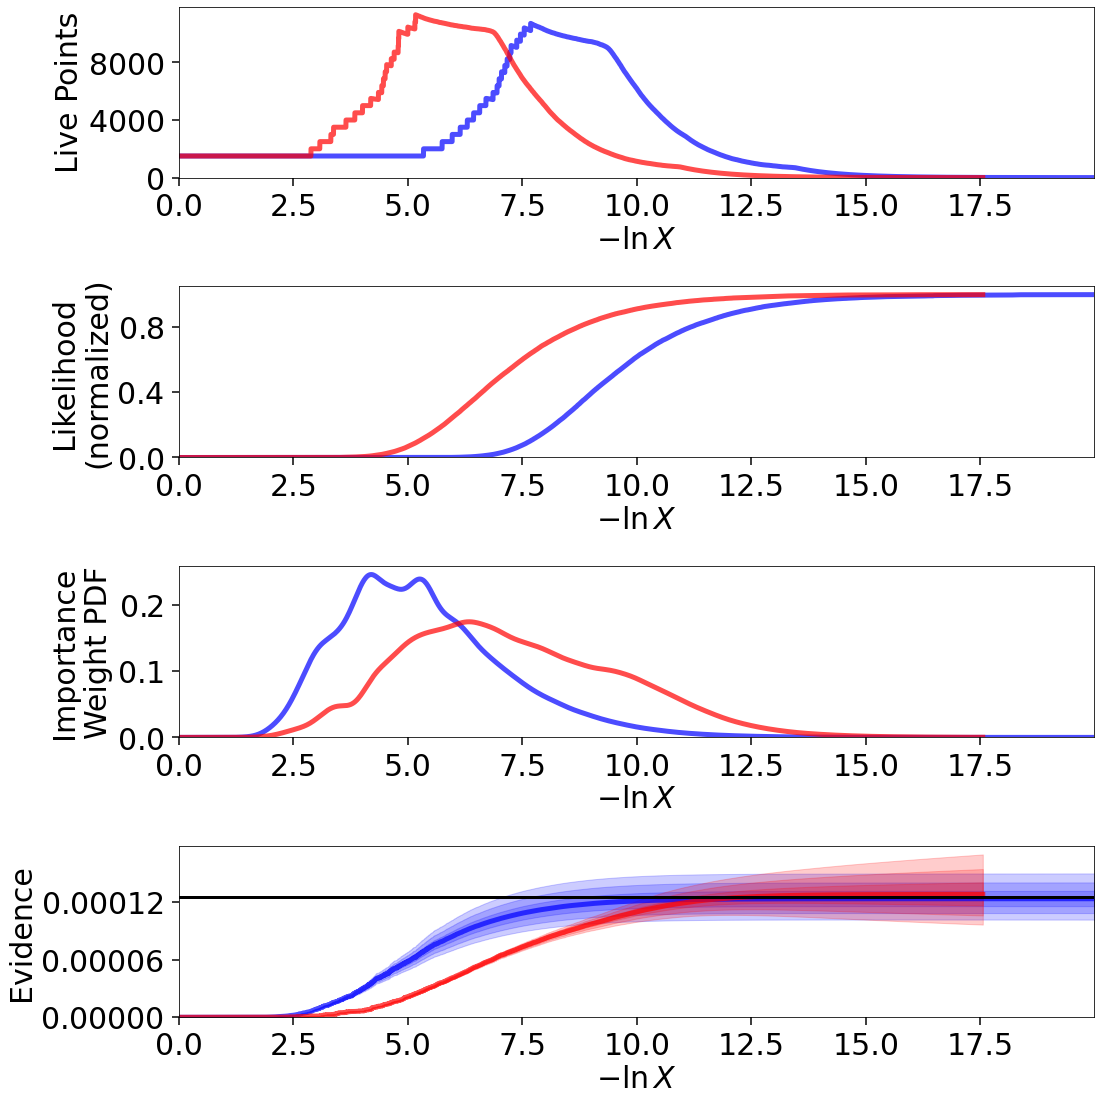

In [13]:
# plot results
fig, axes = dyplot.runplot(dres_rwt, color='blue')
fig, axes = dyplot.runplot(dres2_rwt, color='red', 
                           lnz_truth=lnz_truth, truth_color='black',
                           fig=(fig, axes))
fig.tight_layout()

We see that while we are able to reproduce the broad features of each distribution, the reweighted estimates are quite noisy.